In [1]:
import os
import torch
torch.set_default_dtype(torch.double)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on PyTorch {torch.__version__}')
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

Running on PyTorch 1.12.1


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import NearestNDInterpolator
from pyDOE import lhs

# data loading
df = pd.read_csv('Case3_finer.csv')
X_data  = np.vstack([df["alpha0"].to_numpy() ,
                        df["alpha1"].to_numpy() ,
                        df["alpha2"].to_numpy() ,
                        df["alpha3"].to_numpy() ])
Cx_data = df['SumCx'].to_numpy() 
Cx_data = StandardScaler().fit_transform(Cx_data.reshape(-1,1))
pts_original = X_data.T.copy()
pts_original = StandardScaler().fit_transform(pts_original)
# compute PCA 
pca = PCA(n_components=4, svd_solver='full').fit(pts_original)
pts_transformed = pca.transform(pts_original)
#self.pts_transformed = self.pts_original

# Sample RSMs
dim = 4
N = 10000
lb = np.min(pts_transformed,axis=0)
ub = np.max(pts_transformed,axis=0)
bounds = {'lb': lb, 'ub': ub}
pts = lb + (ub - lb) * lhs(dim, N) # generate latin-hypercube
# But Pts are not in convex hull of pts_transformed (LD interpolator does not extrapolate) 
r =  NearestNDInterpolator(pts_transformed, Cx_data)
# pts has be inside region of interpolation .
valuesTrasf = r(pts) 
data = np.vstack([pts.T,valuesTrasf.reshape(-1,1).T]).T

In [61]:
from torch.utils.data import TensorDataset, DataLoader, Dataset

def hifi_function(x):
    return (0.1 * torch.sin(40 * x) + (((2 * x) ** 2) / 3)).squeeze().clone().detach()

def outcome_constraint(X):
    """L1 constraint; feasible if less than or equal to zero."""
    return X.sum(dim=-1) - 1

def weighted_obj(X):
    """Feasibility weighted objective; zero if not feasible."""
    return hifi_function(X) * (outcome_constraint(X) <= 0).type_as(X)

from botorch.models import (FixedNoiseGP, 
                            ModelListGP,
                            SingleTaskGP,
                            )
from gpytorch.mlls.sum_marginal_log_likelihood import (
                                                   SumMarginalLogLikelihood, 
                                                   ExactMarginalLogLikelihood,
                                                   )
from gpytorch.mlls import LeaveOneOutPseudoLikelihood

NOISE_SE = 0.5
NOISE_NN = 0.01
train_yvar = torch.tensor(NOISE_SE**2, device=device, dtype=dtype)
train_nn_yvar = torch.tensor(NOISE_NN**2, device=device, dtype=dtype)
n = 10
def generate_initial_data(n):
    # generate training data
    train_x = torch.rand(n, 1, device=device, dtype=dtype)
    exact_obj = hifi_function(train_x).unsqueeze(-1)  # add output dimension
    exact_con = outcome_constraint(train_x).unsqueeze(-1)  # add output dimension
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    train_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    best_observed_value = weighted_obj(train_x).max().item()
    return train_x, train_obj, train_con, best_observed_value

from sklearn.model_selection import train_test_split
import numpy as np
def get_data(n):
    # generate data for training, testing and validating the neural network model (high fidelity)
    x = torch.rand(2*n, 1, device=device, dtype=dtype)
    exact_obj = hifi_function(x).unsqueeze(-1)  # add output dimension
    exact_con = outcome_constraint(x).unsqueeze(-1)  # add output dimension
    obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    (
     train_x, 
     test_x, 
     train_obj, 
     test_obj, 
     train_con, 
     test_con
     ) = train_test_split(np.asarray(x), 
                                  np.asarray(obj), 
                                  np.asarray(con), 
                                  test_size=0.5
                                  )
    (
     valid_x, 
     test_x, 
     valid_obj, 
     test_obj, 
     valid_con, 
     test_con
     ) = train_test_split(test_x, 
                            test_obj, 
                            test_con, 
                            test_size=0.5
                            )
    return (
        torch.tensor(train_x  , device=device, dtype=dtype),
        torch.tensor(train_obj, device=device, dtype=dtype),
        torch.tensor(train_con, device=device, dtype=dtype),
        torch.tensor(test_x   , device=device, dtype=dtype),
        torch.tensor(test_obj , device=device, dtype=dtype),
        torch.tensor(test_con , device=device, dtype=dtype),
        torch.tensor(valid_x  , device=device, dtype=dtype),
        torch.tensor(valid_obj, device=device, dtype=dtype),
        torch.tensor(valid_con, device=device, dtype=dtype)
             )

In [3]:
def initialize_model(train_x, train_obj, train_con, state_dict=None):
    # define models for objective and constraint
    train_multi_yvar = NOISE_SE**2*torch.ones(train_x.shape[0],1, device=device, dtype=dtype)
    train_multi_yvar[n:] = NOISE_NN**2
    model_obj = FixedNoiseGP(train_x, train_obj, train_multi_yvar).to(
        train_x
    )
    model_con = FixedNoiseGP(train_x, train_con, train_multi_yvar).to(
        train_x
    )
    # combine into a multi-output GP model
    model = ModelListGP(model_obj, model_con)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    # loocv = gpytorch.mlls.LeaveOneOutPseudoLikelihood(likelihood, model)
    
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

def initialize_single_model(train_x, train_obj, state_dict=None):
    # define models for objective and constraint
    train_multi_yvar = NOISE_SE**2*torch.ones(train_x.shape[0],1, device=device, dtype=dtype)
    train_multi_yvar[n:] = NOISE_NN**2
    model_obj = FixedNoiseGP(train_x, train_obj, train_multi_yvar).to(
        train_x
    )

    #mll = SumMarginalLogLikelihood(model_obj.likelihood, model_obj)
    loocv = LeaveOneOutPseudoLikelihood(model_obj.likelihood, model_obj)
    
    # load state dict if it is passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return loocv, model_obj

In [4]:
from botorch.acquisition.objective import ConstrainedMCObjective

def obj_callable(Z):
    return Z[..., 0]


def constraint_callable(Z):
    return Z[..., 1]


# define a feasibility-weighted objective for optimization
constrained_obj = ConstrainedMCObjective(
    objective=obj_callable,
    constraints=[constraint_callable],
)

In [5]:
from torch import nn
# Define hyperparameters
n_samples, n_features = 1,1
input_size = n_features
hidden_size = 128
output_size = 1
learning_rate = 1e-2
# Define the neural network model (input, hidden, output size)
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(NeuralNet, self).__init__()
        # Define layers
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU() # activation function nn.LeakyReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        #out = self.sigmoid(out)
        return out

In [100]:
(train_x_nn, 
 train_obj_nn,
 train_con,
 train_x_test, 
 train_obj_test,
 test_con,
 train_x_validation, 
 train_obj_validation,
 valid_con) = get_data(n=2000)

hifi_dataset = TensorDataset(train_x_nn, train_obj_nn)
hifi_dataloader = DataLoader(hifi_dataset, batch_size = 32, shuffle=True)

test_dataset = TensorDataset(train_x_test, train_obj_test)
test_dataloader = DataLoader(hifi_dataset, batch_size = 32, shuffle=True)

nn_model = NeuralNet(input_size,hidden_size,output_size).to(device)
print(nn_model)

# Construct loss and optmizer 
criterion = nn.MSELoss() # Mean Square Error Loss # loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate) # from the optimization module

# In a single training epoch, the model makes predictions on the training dataset (fed to it in batches)
# and backpropagates the prediction error to update the model’s parameters

# Training loop:
#  - forward pass: compute predictions
#  - backward pass: gradients
#  - update weights
num_epochs = 300000 if not SMOKE_TEST else 5 # epoch -> forward and backward of ALL training samples
for epoch in range(num_epochs):
    size = len(hifi_dataloader.dataset)
    nn_model.train()
    for batch, (X, y) in enumerate(hifi_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = nn_model(X)         # prediction: forward pass
        loss = criterion(pred, y) # loss

        # Backpropagation
        optimizer.zero_grad()   # clears old gradients from the last step
        loss.backward()         # gradients: backward pass
        optimizer.step()        # update weights

    if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} / {num_epochs}, step [{batch+1}/{len(hifi_dataloader)}] loss: {loss:.4f}")
            
cwd = os.getcwd()
file_name = "nn_model.pt"
model_file = "nn_model_state.pt"
full_path = os.path.join(cwd, file_name)
torch.save(nn_model, full_path)
torch.save(nn_model.state_dict(), os.path.join(cwd, model_file))

''' Test '''   
nn_model.eval()
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
test_loss, correct, num_samples = 0, 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = nn_model(X)
        test_loss += criterion(pred, y).item()
        num_samples += y.shape[0]
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
acc = 100.0 * correct / num_samples
print(f"Test Error -> Test loss: {test_loss:>8f} \n") # Acc: {acc:>8f}

''' Prediction '''
#def pred(new_point, model):
#    with torch.no_grad():
#            pred_point = model(new_point)
#    return pred_point '''


NeuralNet(
  (linear1): Linear(in_features=1, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 10 / 300000, step [32/32] loss: 0.0042
Epoch 20 / 300000, step [32/32] loss: 0.0060
Epoch 30 / 300000, step [32/32] loss: 0.0068
Epoch 40 / 300000, step [32/32] loss: 0.0067
Epoch 50 / 300000, step [32/32] loss: 0.0075
Epoch 60 / 300000, step [32/32] loss: 0.0048
Epoch 70 / 300000, step [32/32] loss: 0.0030
Epoch 80 / 300000, step [32/32] loss: 0.0060
Epoch 90 / 300000, step [32/32] loss: 0.0051
Epoch 100 / 300000, step [32/32] loss: 0.0061
Epoch 110 / 300000, step [32/32] loss: 0.0041
Epoch 120 / 300000, step [32/32] loss: 0.0052
Epoch 130 / 300000, step [32/32] loss: 0.0018
Epoch 140 / 300000, step [32/32] loss: 0.0055
Epoch 150 / 300000, step [32/32] loss: 0.0059
Epoch 160 / 300000, step [32/32] loss: 0.0036
Epoch 170 / 300000, step [32/32] loss: 0.0039
Epoch 180 / 300000, st

' Prediction \ndef pred(new_point, model):\n    with torch.no_grad():\n            pred_point = model(new_point)\n    return pred_point '

In [107]:
(pred.argmax(1)) 


tensor([0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
''' SAVE THE NEURAL NETWORK MODEL'''
# define the directory path and file name
cwd = os.getcwd()
file_name = "nn_model.pt"
model_file = "nn_model_state.pt"

# concatenate the directory path and file name to create the full file path
full_path = os.path.join(cwd, file_name)
print(full_path)

# save the model to the full file path
torch.save(nn_model, full_path)
torch.save(nn_model.state_dict(), os.path.join(cwd, model_file))


c:\Users\Utente\Documents\Python\Geoinformatics_Project\nn_model.pt


In [83]:
nn_model = NeuralNet(input_size,hidden_size,output_size).to(device)
nn_model.load_state_dict(torch.load(os.path.join(cwd, model_file)))
nn_model.eval()

NeuralNet(
  (linear1): Linear(in_features=1, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [81]:
# Import model saved
nn_model = torch.load(full_path)
nn_model.eval()

NeuralNet(
  (linear1): Linear(in_features=1, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [8]:
from botorch.optim import optimize_acqf


bounds = torch.tensor([[0.0] * 1, [1.0] * 1], device=device, dtype=dtype)

BATCH_SIZE = 1 if not SMOKE_TEST else 1
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values and get new obj
    new_x = candidates.detach()
    exact_con = outcome_constraint(new_x).unsqueeze(-1)  # add output dimension
    new_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    with torch.no_grad():
        new_obj = nn_model(new_x)    
    return new_x, new_obj, new_con

def optimize_single_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 10, "maxiter": 200},
    )
    # observe new values and get new obj
    new_x = candidates.detach()
    with torch.no_grad():
        new_obj = nn_model(new_x)
    return new_x, new_obj


def update_random_observations(best_random):
    """Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = torch.rand(BATCH_SIZE, 1)
    next_random_best = weighted_obj(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))
    return best_random

In [71]:
from botorch import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
)
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
import gpytorch
import time
import warnings

warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


N_TRIALS = 1 if not SMOKE_TEST else 2
N_BATCH = 10 if not SMOKE_TEST else 2
MC_SAMPLES = 256 if not SMOKE_TEST else 32

verbose = False

best_observed_all_qEI, best_observed_all_qNEI, best_observed_all_EI, best_random_all = [], [], [], []

cvg_loss = 0.03
test_loss = 1

while test_loss > cvg_loss:
# average over multiple trials
    for trial in range(1, N_TRIALS + 1):

        print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
        best_observed_qEI, best_observed_qNEI, best_observed_EI, best_random = [], [], [], []

        # call helper functions to generate initial training data and initialize model
        (
                train_x_qEI,
                train_obj_qEI,
                train_con_qEI,
                best_observed_value_qEI,
            ) = generate_initial_data(n=10)

        train_x_qNEI, train_obj_qNEI, train_con_qNEI = train_x_qEI, train_obj_qEI, train_con_qEI
        train_x_EI, train_obj_EI = train_x_qEI, train_obj_qEI

        best_observed_value_qNEI = best_observed_value_qEI
        best_observed_value_EI = best_observed_value_qEI

        mll_qEI, model_qEI = initialize_model(train_x_qEI, train_obj_qEI, train_con_qEI)
        mll_qNEI, model_qNEI = initialize_model(train_x_qNEI, train_obj_qNEI, train_con_qNEI)
        mll_EI, model_EI = initialize_single_model(train_x_EI, train_obj_EI)


        best_observed_qEI.append(best_observed_value_qEI)
        best_observed_qNEI.append(best_observed_value_qNEI)
        best_observed_EI.append(best_observed_value_EI)

        best_random.append(best_observed_value_qEI)

        # run N_BATCH rounds of BayesOpt after the initial random batch
        for iteration in range(1, N_BATCH + 1):
        #while test_loss > cvg_loss and iteration<100:

            t0 = time.monotonic()

            # fit the models
            fit_gpytorch_mll(mll_qEI)
            fit_gpytorch_mll(mll_qNEI)
            fit_gpytorch_mll(mll_EI)


            # define the qEI and qNEI acquisition modules using a QMC sampler
            qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

            # for best_f, we use the best observed noisy values as an approximation
            qEI = qExpectedImprovement(
                model=model_qEI,
                best_f=(train_obj_qEI * (train_con_qEI <= 0).to(train_obj_qEI)).max(),#
                sampler=qmc_sampler,
                objective=constrained_obj,
            )

            qNEI = qNoisyExpectedImprovement(
                model=model_qNEI,
                X_baseline=train_x_qNEI,
                sampler=qmc_sampler,
                objective=constrained_obj,
            )

            EI = ExpectedImprovement(
                model=model_EI,
                best_f=(train_obj_EI).max()
            )

            # optimize and get new observation
            new_x_qEI, new_obj_qEI, new_con_qEI = optimize_acqf_and_get_observation(qEI)
            new_x_qNEI, new_obj_qNEI, new_con_qNEI = optimize_acqf_and_get_observation(qNEI)
            new_x_EI, new_obj_EI = optimize_single_acqf_and_get_observation(EI)
            
            # print(f"Iter {iter+1}/{N_ITER} - next points: {new_X}\n pred objectives: {predicted_optimal_obj}")

            # update training points
            train_x_qEI = torch.cat([train_x_qEI, new_x_qEI])
            train_obj_qEI = torch.cat([train_obj_qEI, new_obj_qEI])
            train_con_qEI = torch.cat([train_con_qEI, new_con_qEI])

            train_x_qNEI = torch.cat([train_x_qNEI, new_x_qNEI])
            train_obj_qNEI = torch.cat([train_obj_qNEI, new_obj_qNEI])
            train_con_qNEI = torch.cat([train_con_qNEI, new_con_qNEI])

            train_x_EI = torch.cat([train_x_EI, new_x_EI])
            train_obj_EI = torch.cat([train_obj_EI, new_obj_EI])
            
            # update progress
            best_random = update_random_observations(best_random)
            best_value_qEI = weighted_obj(train_x_qEI).max().item()
            best_value_qNEI = weighted_obj(train_x_qNEI).max().item()
            best_value_EI = weighted_obj(train_x_EI).max().item()

            best_observed_qEI.append(best_value_qEI)
            best_observed_qNEI.append(best_value_qNEI)
            best_observed_EI.append(best_value_EI)

            # reinitialize the models so they are ready for fitting on next iteration
            # use the current state dict to speed up fitting
            mll_qEI, model_qEI = initialize_model(
                train_x_qEI,
                train_obj_qEI,
                train_con_qEI,
                model_qEI.state_dict(),
            )
            mll_qNEI, model_qNEI = initialize_model(
                train_x_qNEI,
                train_obj_qNEI,
                train_con_qNEI,
                model_qNEI.state_dict(),
            )

            mll_EI, model_EI = initialize_single_model(
                train_x_EI,
                train_obj_EI,
            )

            t1 = time.monotonic()

            if verbose:
                print(
                    f"\nBatch {iteration:>2}: best_value (random, qEI, qNEI) = "
                    f"({max(best_random):>4.2f}, {best_value_qEI:>4.2f}, {best_value_qNEI:>4.2f}), "
                    f"time = {t1-t0:>4.2f}.",
                    end="",
                )
            else:
                print(".", end="")# sep ","
        
            '''validation_dataset = TensorDataset(train_x_validation, train_obj_validation)
            validation_dataloader = DataLoader(validation_dataset, batch_size = 32, shuffle=True)

            fit_gpytorch_mll(mll_EI)
            model_EI.eval()
            loss_criterion = nn.MSELoss() 

            # validation
            size = len(validation_dataloader.dataset)
            num_batches = len(validation_dataloader)
            test_loss, correct, num_samples = 0, 0, 0
            with torch.no_grad():
                for X, y in test_dataloader:
                    X, y = X.to(device), y.to(device)
                    test_obj = model_EI(X)
                    test_loss += loss_criterion(test_obj.mean, y).item()
            test_loss /= num_batches
            model_EI.train()
            iteration +=1'''
            
        best_observed_all_qEI.append(best_observed_qEI)
        best_observed_all_qNEI.append(best_observed_qNEI)
        best_observed_all_EI.append(best_observed_EI)
        best_random_all.append(best_random)
        
print(test_loss)
   


Trial  1 of 1 ....................................................................................................
Trial  1 of 1 ....................................................................................................
Trial  1 of 1 ...................................................................................................

ModelFittingError: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.

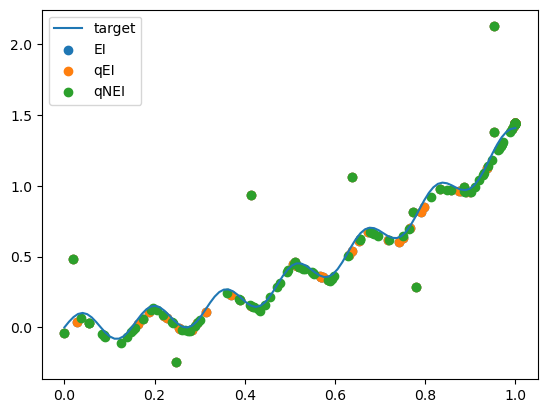

In [87]:
from matplotlib import pyplot as plt
fig = plt.figure()
test_x = torch.linspace(0, 1, 100)
ax = fig.add_subplot()
ax.plot(test_x.numpy(), hifi_function(test_x).numpy(),label = 'target')
ax.scatter(train_x_qEI.numpy(), train_obj_qEI.numpy(),label = 'EI')
ax.scatter(train_x_qEI.numpy(), train_obj_qEI.numpy(),label = 'qEI')
ax.scatter(train_x_qNEI.numpy(), train_obj_qNEI.numpy(),label = 'qNEI')


plt.legend()

In [84]:
from gpytorch.models import ExactGP
# Define the Kernel of Gaussian Process
class ExactGPModel(ExactGP):
    def __init__(self,X_train, Y_train,likelihood):
        super(ExactGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

ei - Iter 100/3200 - Loss: 0.81802 LenghtParam 0.64738
ei - Iter 200/3200 - Loss: 0.78069 LenghtParam 0.61078
ei - Iter 300/3200 - Loss: 0.74329 LenghtParam 0.58354
ei - Iter 400/3200 - Loss: 0.70560 LenghtParam 0.56481
ei - Iter 500/3200 - Loss: 0.66749 LenghtParam 0.55334
ei - Iter 600/3200 - Loss: 0.62890 LenghtParam 0.54766
ei - Iter 700/3200 - Loss: 0.58984 LenghtParam 0.54614
ei - Iter 800/3200 - Loss: 0.55035 LenghtParam 0.54724
ei - Iter 900/3200 - Loss: 0.51051 LenghtParam 0.54971
ei - Iter 1000/3200 - Loss: 0.47041 LenghtParam 0.55265
ei - Iter 1100/3200 - Loss: 0.43015 LenghtParam 0.55551
ei - Iter 1200/3200 - Loss: 0.38983 LenghtParam 0.55797
ei - Iter 1300/3200 - Loss: 0.34954 LenghtParam 0.55989
ei - Iter 1400/3200 - Loss: 0.30941 LenghtParam 0.56122
ei - Iter 1500/3200 - Loss: 0.26953 LenghtParam 0.56198
ei - Iter 1600/3200 - Loss: 0.23001 LenghtParam 0.56218
ei - Iter 1700/3200 - Loss: 0.19097 LenghtParam 0.56187
ei - Iter 1800/3200 - Loss: 0.15251 LenghtParam 0.56111
e

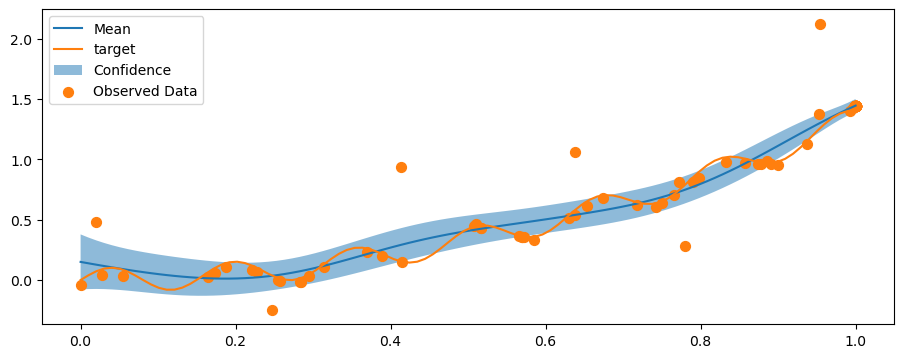

In [86]:
fig = plt.figure(figsize=(11, 9))

''' fit the model '''
likelihood = gpytorch.likelihoods.GaussianLikelihood()

train_multi_yvar = NOISE_SE**2*torch.ones(train_x_qEI.shape[0],1, device=device, dtype=dtype)
train_multi_yvar[n:] = NOISE_NN**2
''' Define the model '''
#gp_model = FixedNoiseGP(train_x_qEI, train_obj_qEI, train_multi_yvar)
gp_model = SingleTaskGP(train_x_qEI, train_obj_qEI, likelihood)
#gp_model = ExactGPModel(train_x_qEI, train_obj_qEI.squeeze(), likelihood)
    # Find optimal model hyperparameters
gp_model.train()
likelihood.train()
optimizer = torch.optim.Adam(gp_model.parameters(),lr=1e-3) # Use the adam optimizer  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model) # "Loss" for GPs - the marginal log likelihood
#mll = gpytorch.mlls.LeaveOneOutPseudoLikelihood(likelihood, gp_model) # "Loss" for GPs - LOO Pseudo likelihood

training_iter  = 3200 if not SMOKE_TEST else 4
for i in range(training_iter):
    optimizer.zero_grad()    # Zero gradients from previous iteration
    output = gp_model(train_x_qEI)        # Output from model
    loss = -mll(output, train_obj_qEI.squeeze())     # compute loss and backprop gradients
    loss.backward()
    if (i+1) % 100 == 0:
        print(f'ei - Iter {i + 1}/{training_iter} - Loss: {loss.item():.5f} LenghtParam {gp_model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0]:.5f}')
    optimizer.step()
print('\n')

gp_model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100).double()
    observed_pred = (gp_model(test_x))      # Make predictions by feeding model through likelihood
    ax = fig.add_subplot(2, 1, 1)      # Initialize plot
    lower, upper = observed_pred.confidence_region()     # Get upper and lower confidence bounds
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), label = 'Mean')     # Plot predictive means as blue line
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence')  # Shade between the lower and upper confidence bounds
    ax.plot(test_x.numpy(), hifi_function(test_x).numpy(),label = 'target')
    ax.scatter(train_x_qEI.numpy(), train_obj_qEI.numpy(), s=50,label = 'Observed Data')
    ax.legend()
    # PAY ATTENTION TO CI
plt.show()